# Exploration of Neural Network libraries in Python:
# Training a Feedforward Neural Network for Regression

#### 1. Benchmark: Logistic Regression (scikit-learn)
    
#### 2. Classification
    2.1 Benchmark
    2.2 Keras NN
    2.3 Ensamble of models

#### 3. Regression
    3.1 Benchmark
    3.2 Keras NN
    
#### 4. PyBrain
    4.1 

In [12]:
import sys, os
sys.path.append(os.path.join(os.getcwd().split('ICM')[0], 'ICM', 'code'))
import ICM_utils

In [13]:
import pandas as pd
pd.options.mode.chained_assignment = None

import numpy as np
import matplotlib.pyplot as plt

from sklearn import linear_model
from sklearn.ensemble import VotingClassifier
from sklearn.cross_validation import KFold, cross_val_score
from sklearn.svm import LinearSVC
from sklearn.datasets import make_classification
# from sklearn.preprocessing import LabelEncoder
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.grid_search import GridSearchCV, RandomizedSearchCV
# from sklearn.cross_validation import train_test_split
# from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from keras import metrics
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Activation, Dense, BatchNormalization, Dropout
from keras import optimizers
from keras.wrappers.scikit_learn import KerasRegressor, KerasClassifier
from keras.utils.np_utils import to_categorical

%matplotlib inline 
import time, math

In [14]:
IMC_basedir = os.getcwd().split('code')[0]
DATA_AMELIA_FILE = os.path.join(IMC_basedir, 'data/imputed_dataset_no_censoring_26022018_Amelia1.csv')
DATA_MICE_FILE = os.path.join(IMC_basedir, 'data/imputed_dataset_no_censoring_26022018_MICE.csv')
TRAIN_FILE = os.path.join(IMC_basedir, 'data/amelia_train')
TEST_FILE = os.path.join(IMC_basedir, 'data/amelia_test')
MODEL_DIR = os.path.join(IMC_basedir, 'data/amelia_model')

In [15]:
df, labels = ICM_utils.process_amelia(DATA_AMELIA_FILE)

In [17]:
X_train_r, Y_train_r, X_test_r, Y_test_r = ICM_utils.get_train_test_data(df, regression=True, train_size=0.8)
X_train_c, Y_train_c, X_test_c, Y_test_c = ICM_utils.get_train_test_data(df, regression=False, train_size=0.8)

## 1. Benchmark Logistic Regression (Scikit-learn)

             precision    recall  f1-score   support

    6months       0.20      0.09      0.13        95
    1.2year       0.38      0.53      0.44       111
     2years       0.18      0.06      0.08        54
     3years       0.41      0.45      0.43        58
       more       0.55      0.75      0.64       100

avg / total       0.36      0.41      0.37       418

Accuracy: 0.41148325358851673
Mean square error (MSE): 3.08
R^2: 0.41


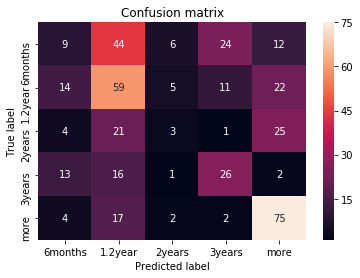

In [18]:
# Create logistic regression object
regr = linear_model.LogisticRegression()             
regr.fit(X_train_c, Y_train_c) 

Y_pred = regr.predict(X_test_c)
            
ICM_utils.plot_report(Y_test_c, Y_pred, labels)

# print ('Coefficients:', regr.coef_, regr.intercept_ )               
print("Mean square error (MSE): %.2f"
      % np.mean((Y_pred - Y_test_c) ** 2))      # The mean square error
print ('R^2: %.2f' % regr.score(X_test_c, Y_test_c) )  # Explained variance score

In [19]:
# Regression

In [20]:
regr = LinearSVC()
regr.fit(X_train_r, Y_train_r) 

Y_pred = regr.predict(X_test_r)

# print ('Coefficients:', regr.coef_, regr.intercept_ )               
print("Mean square error (MSE): %.2f"
      % np.mean((Y_pred - Y_test_r) ** 2))      # The mean square error
print ('R^2: %.2f' % regr.score(X_test_r, Y_test_r) )  # Explained variance score

Mean square error (MSE): 2872468.92
R^2: 0.00


### 1.1 Benchmark Linear SVC

In [11]:
svc = LinearSVC(random_state=0)
svc.fit(X_train_c, Y_train_c)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=0, tol=0.0001,
     verbose=0)

             precision    recall  f1-score   support

    1.5year       0.52      0.99      0.68       198
     4years       1.00      0.02      0.04       137
       more       0.92      0.40      0.55        83

avg / total       0.76      0.56      0.45       418

Accuracy: 0.5574162679425837
Mean square error (MSE): 0.81
R^2: 0.00


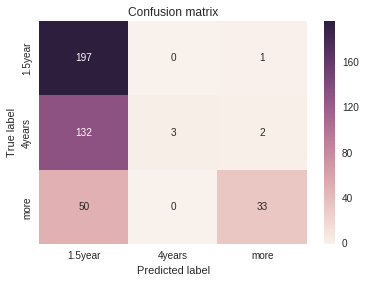

In [13]:
Y_pred = svc.predict(X_test_c)
            
ICM_utils.plot_report(Y_test_c, Y_pred, labels)

# print ('Coefficients:', regr.coef_, regr.intercept_ )               
print("Mean square error (MSE): %.2f"
      % np.mean((Y_pred - Y_test_c) ** 2))      # The mean square error
print ('R^2: %.2f' % regr.score(X_test_c, Y_test_c) )  # Explained variance score

In [14]:
# Regression

In [15]:
svc = LinearSVC(random_state=0)
svc.fit(X_train_r, Y_train_r)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=0, tol=0.0001,
     verbose=0)

In [17]:
Y_pred = svc.predict(X_test_r)
            
# print ('Coefficients:', regr.coef_, regr.intercept_ )               
print("Mean square error (MSE): %.2f"
      % np.mean((Y_pred - Y_test_r) ** 2))      # The mean square error
print ('R^2: %.2f' % regr.score(X_test_r, Y_test_r) )  # Explained variance score

Mean square error (MSE): 3293755.38
R^2: 0.00


## 2.1 Classification: Benchmark

In [30]:
# need the full dataset for cross validation
X = df.copy(deep=True)

Y = np.array(X['life_expectancy_bin'])
# remove columns
X.drop('life_expectancy', axis = 1, inplace=True)
X.drop('life_expectancy_bin', axis = 1, inplace=True)

X = np.array(X)

In [35]:
# define baseline model
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(8, input_dim=54, activation='relu'))
    model.add(Dense(len(labels), activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [36]:
estimator = KerasClassifier(build_fn=baseline_model, epochs=100, batch_size=5, verbose=0)

In [37]:
results = cross_val_score(estimator, X, Y, cv=KFold(n=X.shape[0], n_folds=2, shuffle=True))
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Baseline: 42.57% (0.29%)


## 2.1 Classification: Keras NN

In [38]:
seed = 7
np.random.seed(seed)

model = Sequential()
# model.add(Dense(108, input_shape=(54,), kernel_initializer='normal', activation='relu'))
# model.add(BatchNormalization())
# model.add(Dense(32, kernel_initializer='normal', activation='relu'))
# model.add(Dropout(0.2))
# model.add(Dense(16, kernel_initializer='normal', activation='relu'))
# model.add(Dropout(0.2))
# model.add(Dense(8, kernel_initializer='normal', activation='relu'))
# model.add(Dropout(0.2))
# model.add(Dense(1, activation='sigmoid'))

model.add(Dense(64, activation='relu', input_dim=54))
model.add(Dropout(0.1))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(3, activation='softmax'))

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

# model.add(Dense(input_dim=54, output_dim=12, activation='relu'))
# model.add(Dropout(0.1))
# model.add(Dense(input_dim=12, output_dim=12, activation='relu'))
# model.add(Dropout(0.1))
# model.add(Dense(output_dim=1, activation='softmax'))
# model.compile(loss='mean_squared_error', optimizer='adadelta', metrics=['accuracy'])

# 3
#tbCallBack = keras.callbacks.TensorBoard(log_dir='/tmp/keras_logs', write_graph=True)

# 4
#model.compile(loss='mean_squared_error', optimizer='adadelta', metrics=['accuracy'])

model.summary()

hist = model.fit(np.array(X_train), np.array(to_categorical(Y_train)), 
                 epochs=600, batch_size=128,  verbose=1, validation_split=0.3)#, callbacks=[tbCallBack])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 64)                3520      
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 3)                 195       
Total params: 7,875
Trainable params: 7,875
Non-trainable params: 0
_________________________________________________________________


NameError: name 'X_train' is not defined

In [ ]:
ICM_utils.plot_hist(hist)

In [ ]:
hist = model.fit(np.array(X_train), np.array(to_categorical(Y_train)), 
                 epochs=120, batch_size=128,  verbose=0, validation_split=0.3)#, callbacks=[tbCallBack])

In [ ]:
Y_pred = model.predict(np.array(X_test))

In [ ]:
Y_pred = Y_pred.argmax(axis=-1)

In [ ]:
ICM_utils.plot_report(Y_test, Y_pred, labels)

## 2.3 Classification: Ensamble of models

In [ ]:
def mlp_model():
    model = Sequential()
    
    model.add(Dense(50, input_dim = 54, kernel_initializer='he_normal', activation='relu'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Dense(50, kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))    
    model.add(Dropout(0.2))
    model.add(Dense(50, kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Dense(50, kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Dense(3, kernel_initializer='he_normal'))
    model.add(Activation('softmax'))
    
    adam = optimizers.Adam(lr = 0.001)
    model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
    
    return model

In [ ]:
mp = mlp_model()

In [ ]:
hist = mp.fit(np.array(X_train_c), np.array(to_categorical(Y_train_c)), epochs=600, batch_size=128,  verbose=0, 
              validation_split=0.3)#, callbacks=[tbCallBack])

In [ ]:
ICM_utils.plot_hist(hist)

In [ ]:
# create 5 models to ensemble
model1 = KerasClassifier(build_fn = mlp_model, epochs = 150)
model2 = KerasClassifier(build_fn = mlp_model, epochs = 150)
model3 = KerasClassifier(build_fn = mlp_model, epochs = 150)
model4 = KerasClassifier(build_fn = mlp_model, epochs = 150)
model5 = KerasClassifier(build_fn = mlp_model, epochs = 150)

ensemble_clf = VotingClassifier(estimators = [('model1', model1), ('model2', model2), 
                                              ('model3', model3), ('model4', model4), 
                                              ('model5', model5)], voting = 'soft')

In [ ]:
ensemble_clf.fit(np.array(X_train), np.array(Y_train))

In [ ]:
Y_pred = ensemble_clf.predict(np.array(X_test))

In [ ]:
ICM_utils.plot_report(Y_test, Y_pred, labels)

## 3.1 Regression: Benchmark

In [ ]:
def test_kfolds(regressor, x, y, kfolds = [5]):
    for k_folds in kfolds:
        # evaluate model with standardized dataset
        np.random.seed(182)
        estimators = []
        #estimators.append(('standardize', StandardScaler()))
        estimators.append(('mlp', regressor))
        pipeline = Pipeline(estimators)
        kfold = KFold(n=X.shape[0], n_folds=k_folds)
        results = cross_val_score(pipeline, x, y, cv=kfold)
        print("K_folds {}: \nMean {} \nStd {}".format(k_folds, results.mean(), results.std()))

In [ ]:
# Need full dataset for cross validation
X = df.copy(deep=True)

Y = np.array(X['life_expectancy'])
# remove columns
X.drop('life_expectancy', axis = 1, inplace=True)
X.drop('life_expectancy_bin', axis = 1, inplace=True)

X = np.array(X)

In [ ]:
# define base model
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(13, input_dim=54, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=[metrics.MAPE,
                                                                        metrics.MSLE,
                                                                        metrics.MAE])
    return model

In [ ]:
bm = baseline_model()
hist = bm.fit(np.array(X_train_r), np.array(Y_train_r), 
                 epochs=600, batch_size=128,  verbose=0, validation_split=0.3)

In [ ]:
ICM_utils.plot_hist(hist)

In [ ]:
test_kfolds(KerasRegressor(build_fn=baseline_model, nb_epoch=150, batch_size=128, verbose=0), X, Y)

In [ ]:
bm.evaluate(np.array(X_test_r), np.array(Y_test_r))

## 3.2 Regression: Keras NN

In [ ]:
def larger_model():
    # create model
    model = Sequential()
    model.add(Dense(54, kernel_initializer="normal", input_dim=54, activation="relu"))
    model.add(Dense(27, kernel_initializer='normal', activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(15, kernel_initializer='normal', activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [ ]:
test_kfolds(KerasRegressor(build_fn=larger_model, nb_epoch=150, batch_size=128, verbose=0), X, Y)

In [ ]:
def wider_model():
    # create model
    model = Sequential()
    model.add(Dense(540, kernel_initializer="normal", input_dim=54, activation="relu"))
    model.add(Dense(270, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [ ]:
test_kfolds(KerasRegressor(build_fn=wider_model, nb_epoch=150, batch_size=128, verbose=0), X, Y)

## 3.3 Model showdown

Different approach for Classification vs. Regression using Neural Network:
- Training examples: Rn x {class_1, ..., class_n} (one-hot encoding) vs Rn x Rm
- Last layer: softmax vs linear / sigmoid
- Loss function: Cross entropy vs MSE / Absolute error

In [ ]:
model = Sequential()
model.add(Dense(50, kernel_initializer="normal", input_dim=54))
model.add(Activation('relu'))
model.add(Dense(1))
    
model.compile(optimizer = optimizers.SGD(lr = 0.001), loss = 'mean_squared_error', metrics = ['accuracy'])

history = model.fit(np.array(X_train), np.array(Y_train), epochs = 100, verbose = 1)

# plt.plot(history.history['acc'])
# plt.plot(history.history['val_acc'])
# plt.legend(['training', 'validation'], loc = 'upper left')
# plt.show()

results = model.evaluate(np.array(X_test), np.array(Y_test))
print('\nTest accuracy: ', results[1])

In [ ]:
model.summary()

## 3. Pybrain

In [2]:
#!pip install git+https://github.com/pybrain/pybrain.git

  Cloning https://github.com/pybrain/pybrain.git to /private/var/folders/31/8m981_ps2qd58y48l1n9pn94c52j50/T/pip-b58_bar4-build
  Running setup.py install for PyBrain ... done
You are using pip version 9.0.1, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


### 3.1 PyBrain: Regression

In [39]:
from pybrain.structure import SigmoidLayer, LinearLayer, TanhLayer, ReluLayer, SoftmaxLayer
from pybrain.datasets import SupervisedDataSet
from pybrain.supervised.trainers import BackpropTrainer
import pybrain.tools.shortcuts as pb
import numpy, math

# Build the dataset
xvalues = np.array(X_train_r)
yvalues = np.array(Y_train_r)
ds = SupervisedDataSet(54, 1)
for x, y in zip(xvalues, yvalues):
    ds.addSample((x), (y))
    
# Build the NN
nn1 = pb.buildNetwork(54,  # 1 input node
                   108,    # number of nodes in 1st hidden layer
                   72,    # number of nodes in 1st hidden layer
                   54,     # number of nodes in 4th hidden layer
                   1,     # 1 output node
                   bias = True,
                   hiddenclass = SigmoidLayer,
                   outclass = LinearLayer )

# Train the NN
trainer = BackpropTrainer(nn1, ds, learningrate = 0.004, weightdecay=0.01, momentum=0.02) #, verbose = True)
train_mse, validation_mse = trainer.trainUntilConvergence(maxEpochs = 2020, continueEpochs=5, validationProportion=0.2)

##### Note on some of the parameters

**validationProportion**: ratio of the dataset that is used for the validation dataset.
If maxEpochs is given, at most that many epochs are trained. Each time validation error hits a minimum, try for continueEpochs # epochs to find a better one.

**Epoch**: one epoch means that every example has been seen once. It is preferable to track epochs rather than iterations since 
the number of iterations depends on the arbitrary setting of batch size. Batchs are used for example in the minibatch method,
for example, for 1000 examples, the NN is trained on examples 1-100, then examples 101-201, etc.

**Momentum**: 0 < m < 1 is a global parameter which must be determined by trial and error. Momentum simply adds a fraction m of the previous weight update to the current one. When the gradient keeps pointing in the same direction, this will increase the size of the steps taken towards the minimum. It is otherefore often necessary to reduce the global learning rate µ when using a lot of momentum (m close to 1). If you combine a high learning rate with a lot of momentum, you will rush past the minimum with huge steps! When the gradient keeps changing direction, momentum will smooth out the variations. Adding a momentum can help to speed up convergence to the minimum by damping oscillations.

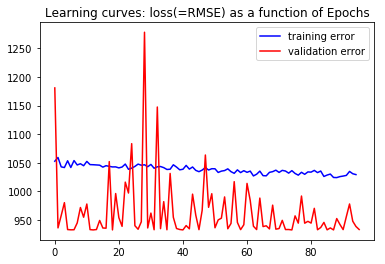

In [40]:
# Learning curves
plt.clf()
plt.plot(range(len(train_mse)), np.sqrt(train_mse), color='blue', label='training error')
plt.plot(range(len(validation_mse)), np.sqrt(validation_mse), color='red', label='validation error')
plt.title('Learning curves: loss(=RMSE) as a function of Epochs')
plt.legend()

In [50]:
xvalues = np.array(X_test_r)
yvalues = np.array(Y_test_r)
ds_t = SupervisedDataSet(54, 1)
for x, y in zip(xvalues, yvalues):
    ds_t.addSample((x), (y))

In [52]:
np.sqrt(trainer.testOnData(ds_t))

925.5541517898837